# Image Deconvolution using Variational Method

This numerical tour explores the use of
Sobolev and TV regularization to perform image deconvolution.

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$


In [1]:
from __future__ import division
from nt_toolbox.general import *
from nt_toolbox.signal import *
%pylab inline
%matplotlib inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


This tour is concerned with the deconvolution problem. The measurement
are assumed to be blurry and noisy:
 $$y=\Phi f_0 + w = h \star f_0 + w$$



Where here |h| is the filter (low pass) and |w| some noise (here assumed
to be white Gaussian).


We consider variational deconvolution methods, that finds a regularizer
through a convex optimization:
 $$f^\star \in \text{argmin}_f \frac{1}{2}\|y-\Phi f\|^2 + \lambda J(f)$$



Where $J(f)$ is a prior energy. In this tour we consider a simple L2
prior (the image is assumed to have a bounded energy), a Sobolev prior
(the image is uniformly smooth) and an approximate total variation (the
image has edges of bounded perimeter).


Note that the parameter $\lambda$ should be carefully chosen to fit the
noise level.

## Image Blurring

Deconvolution corresponds to removing a blur from an image.
We use here a Gaussian blur.


First we load the image to be inpainted.

In [2]:
n = 256
name = 'nt_toolbox/data/hibiscus.bmp'
f0 = load_image(name, n);

Initial image $f_0$.

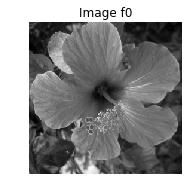

In [3]:
imageplot(f0, 'Image f0', [1, 2, 1])

We build a convolution kernel.
Since we are going to use Fourier to compute the convolution,
we set the center of the kernel in the (1,1) pixel location.

Width $s$ of the kernel, in pixel.

In [4]:
s = 3

Define the convolution kernel $h$.

In [5]:
x = concatenate( (arange(0,n/2), arange(-n/2,0)) );
[Y, X] = meshgrid(x, x)
h = exp((-X**2-Y**2)/ (2*s**2))
h = h/sum(h.flatten())

Useful for later : the Fourier transform (should be real because of symmetry).

In [6]:
hF = real(fft2(h))

Display the kernel and its transform.
We use |fftshift| to center the filter for display.

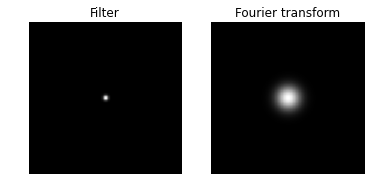

In [7]:
imageplot(fftshift(h), 'Filter', [1, 2, 1])
imageplot(fftshift(hF), 'Fourier transform', [1, 2, 2])

We use this short hand for the filtering.
Note that this is a symmetric operator.

In [8]:
Phi = lambda x,h: real(ifft2(fft2(x) * fft2(h)))

*Important* Scilab user should define a function |Phi| in a separate file |Phi.sci|
to perform this.


Apply the filter.

In [9]:
y0 = Phi(f0, h)

Display the filtered observation.

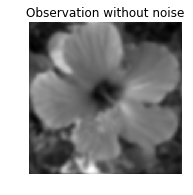

In [10]:
imageplot(y0, 'Observation without noise', [1, 2, 2])

Variance $\sigma^2$ of the noise $w$.

In [11]:
sigma = .02

Add some noise to obtain the measurements $y = \Phi f_0 + w$.

In [12]:
y = y0 + randn(n,n)*sigma

Display.

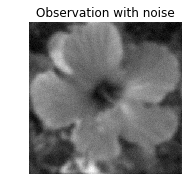

In [13]:
imageplot(clamp(y), 'Observation with noise', [1, 2, 2])

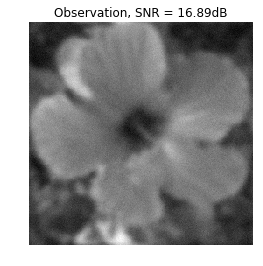

In [14]:
imageplot(y, 'Observation, SNR = ' + str(round(snr(f0, y),2)) + 'dB')

## Deconvolution with L2 Regularization

Deconvolution is obtained by dividing the Fourier transform of $y$
by $\hat h$.
 $$f^\star(\omega) = \frac{\hat y(\omega)}{\hat h(\omega)} = \hat f_0(\omega) + \hat w(\omega)/{\hat h(\omega)}$$


Unfortunately this creates an explosion of the Noise.


To avoid this explosion, we consider a simple regularization.
 $$f^{\star} = \text{argmin}_f \: \|y-\Phi f\|^2 + \lambda \|f\|^2$$



Since the filtering is diagonalized over Fourier, the solution is simply
computed over the Fourier domain as:
 $$\hat f^\star(\omega) = \frac{\hat y(\omega) \hat h(\omega)}{ \|\hat h(\omega)\|^2 + \lambda }$$



Useful for later: Fourier transform of the observations.

In [15]:
yF = fft2(y)

Select a value for the regularization parameter.

In [16]:
Lambda = 0.02

Perform the inversion.

In [17]:
fL2 = real(ifft2(yF * hF / (abs(hF)**2 + Lambda)))

Display.

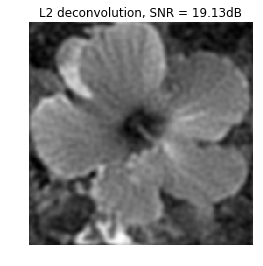

In [18]:
imageplot(clamp(fL2), 'L2 deconvolution, SNR = ' + str(round(snr(f0, fL2),2)) + 'dB')

**Exercise 1:** Find the optimal solution fL2 by testing several value of $\lambda$.

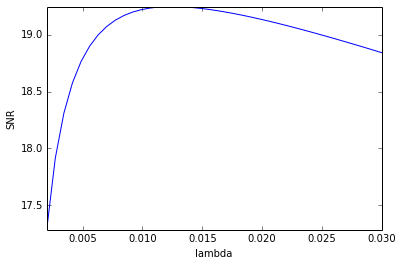

In [19]:
run -i nt_solutions/inverse_2_deconvolution_variational/exo1

Display optimal result.

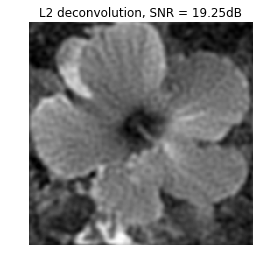

In [20]:
imageplot(clamp(fL2), 'L2 deconvolution, SNR = ' + str(round(snr(f0, fL2), 2)) + 'dB' )

## Deconvolution by Sobolev Regularization.

L2 regularization did not perform any denoising. To remove some noise, we
can penalize high frequencies using Sobolev regularization (quadratic
grow).


The Sobolev prior reads (note the conversion from spacial domain to
Fourier domain)
 $$J(f) = \sum_x \|\nabla f(x)\|^2 = \sum_{\omega} S(\omega) \|\hat f(\omega)\|^2 $$
where $S(\omega)=\|\omega\|^2$.





Since this prior can be written over the Fourier domain, one can compute
the solution to the deblurring with Sobolev prior simply with the Fourier
coefficients:
 $$\hat f^\star(\omega) = \frac{\hat y(\omega) \hat h(\omega)}{ \|\hat h(\omega)\|^2 + \lambda S(\omega) }$$




Compute the Sobolev prior penalty |S|(rescale to [0,1]).

In [21]:
S = (X**2 + Y**2) * (2/n)**2

Regularization parameter:

In [22]:
Lambda = 0.2

Perform the inversion.

In [23]:
fSob = real(ifft2(yF * hF / (abs(hF)**2 + Lambda*S)))

Display the result.

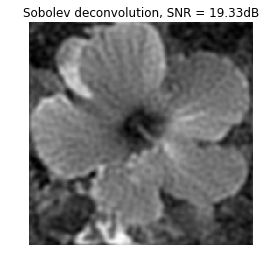

In [24]:
imageplot(clamp(fSob), 'Sobolev deconvolution, SNR = ' + str( round(snr(f0, fSob), 2) ) + 'dB' )

**Exercise 2:** Find the optimal solution fSob by testing several value of
$\lambda$.

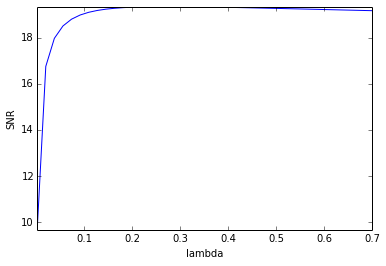

In [25]:
run -i nt_solutions/inverse_2_deconvolution_variational/exo2

Display optimal result.

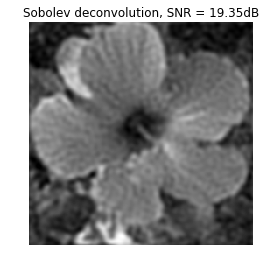

In [26]:
imageplot(clamp(fSob), 'Sobolev deconvolution, SNR = ' + str( round(snr(f0, fSob), 2) ) + 'dB' )

## Deconvolution by Total Variation Regularization

Sobolev regularization perform a denoising but also tends to blur the
edges, thus producing a poor results on cartoon images.


The TV prior is able to better reconstruct sharp edges. It reads:
 $$J(f) = \sum_x \| \nabla f(x)\|$$



With respect to the Sobolev energy, it simply corresponding to measuring
the L1 norm instead of the L2 norm, thus dropping the square in the
functional.


Unfortunately, the TV functional $J(f)$ is not a smooth function of the image
$f$. It thus requires the use of advanced convex optimization method to
be minimized for regularization.


An alternative is to replace the absolute value by a smooth absolute value.
The smoothed TV norm reads:
 $$J(f) = \sum_x \sqrt{\|\nabla f(x)\|^2+\varepsilon^2}$$



Regularization parameter for the TV norm:

In [27]:
epsilon = 0.4*1e-2

When $\epsilon$ gets close to zero, the smoothed energy becomes closer to
the original total variation, but the optimization becomes more
difficult. When |epsilon| becomes large, the smoothed energy becomes
closer to the Sobolev energy, thus blurring the edges.


Unfortunately, this prior is non-quadratic, and cannot be expressed over
the Fourier domain. One thus need to use an iterative scheme such as a
gradient descent to approximate the solution.


An iteration of the gradient descent reads:
 $$f^{(k+1)} = f^{(k)} - \tau \left( h \star (h \star f^{(k)} - y) +  \lambda \text{Grad} J(f^{(k)})  \right)$$



Regularization parameter.

In [28]:
Lambda = 0.06

The value of $\tau$, the step size, should be smaller than twice the
Lipschitz constant of the Gradient of the functional to be minimized,
hence:
$$ \tau< \frac{2}{1 + \lambda 8/\varepsilon }.$$

In [29]:
tau = 1.9 / (1 + Lambda * 8 / epsilon)

Initialization.

In [30]:
fTV = y

Number of iteration (quite a large number is required).

In [31]:
niter = 300

We first check that the discretized grad and -div are adjoint one of each other.

In [32]:
a = randn(n,n)
b = randn(n,n,2)
dotp = lambda x,y: sum(x.flatten()*y.flatten())
print("Should be 0: " + str(dotp(grad(a),b) + dotp(a,div(b))) )

Should be 0: -1.08002495836e-12


The gradient of the smoothed TV energy is:
 $$\text{Grad} J(f) = -\text{div}\left( \frac{\nabla f}{ \sqrt{\|\nabla f\|^2+\varepsilon^2} } \right)$$



Compute the gradient of the smoothed TV functional.

In [33]:
repeat3 = lambda x,k: resize( repeat( x, k, axis=1), [n, n, k])
Gr = grad(fTV)
d = sqrt(epsilon**2 + sum(Gr**2, axis=2))
G = -div(Gr / repeat3(d,2) )

Compute the TV norm, usefull to keep track of its decay through
iterations.

In [34]:
tv = sum(d.flatten())
print('Smoothed TV norm of the image: ' + str(round(tv,2)) )

Smoothed TV norm of the image: 2479.77


Perform a step of gradient descent for the inversion.

In [35]:
e = Phi(fTV, h)-y
fTV = fTV - tau*(Phi(e, h) + Lambda*G)

**Exercise 3:** Perform the deblurring by a  gradient descent.
Keep track of the function being minimized.

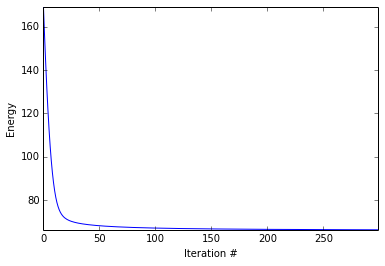

In [36]:
run -i nt_solutions/inverse_2_deconvolution_variational/exo3

Display the result.

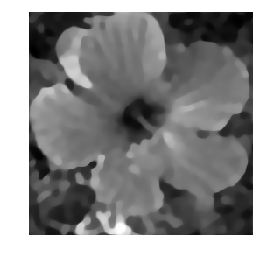

In [39]:
imageplot(clamp(fTV))

### Exercise 4

Explore the different values of |lambda| to find the optimal solution.
Display the SNR as a function of |lambda|.

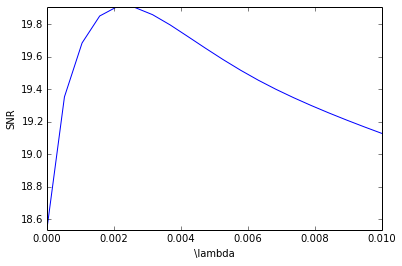

In [40]:
run -i nt_solutions/inverse_2_deconvolution_variational/exo4

Display the result.

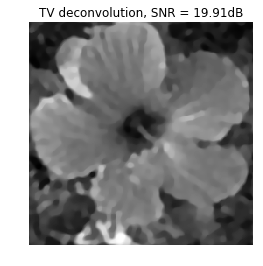

In [41]:
imageplot(clamp(fBest), 'TV deconvolution, SNR = ' + str( round(snr(f0, fBest), 2) ) + 'dB' )